In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

# from simulator import Simulation
from tqdm.auto import tqdm
import itertools
import matplotlib as mpl
from collections import OrderedDict, defaultdict

from voting_mechanism_design.agents.pairwise_badgeholder import PairwiseBadgeholder, PairwiseBadgeholderPopulation
from voting_mechanism_design.projects.project import Project, ProjectPopulation
from voting_mechanism_design.funds_distribution.pairwise_binary import PairwiseBinary
from voting_mechanism_design.sim import RoundSimulation

from voting_mechanism_design.agents.quorum_badgeholder import QuorumBadgeholder, QuorumBadgeholderPopulation
from voting_mechanism_design.funds_distribution.threshold_and_aggregate import ThresholdAndAggregate

# # OP simulator configuration
from voting_mechanism_design.legacy.op_simulator import Simulation as OPSimulation
from voting_mechanism_design.legacy.op_simulator import Round as OPRound
from voting_mechanism_design.legacy.op_simulator import Voter as OPVoter
from voting_mechanism_design.legacy.op_simulator import Project as OPProject

import itertools
import numpy as np
import choix
import math

import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from tqdm.auto import tqdm
from joblib import Parallel, delayed

warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)

In [3]:
def create_monotonic_array(max_val, min_val, length, total_sum):
    x = np.linspace(max_val, min_val, length)
    x /= x.sum()
    x *= total_sum
    
    # if any values exceed the first_value, we need to adjust the values
    mm1 = x[0]
    mm2 = x[-1]
    if mm1 > max_val:
        delta = mm1 - max_val
    else:
        delta = 0
    x = np.linspace(mm1-delta, mm2+delta, length)
    x /= x.sum()
    x *= total_sum

    return x

def run_single_quorum_threshold_simulation_v1(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        # configuration specific to quorum+threshold voting method
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        random_seed=1234
    ):
    round = OPRound(max_funding)
    round.min_project_vote = min_vote_amt
    round.max_project_vote = max_vote_amt
    rng = np.random.default_rng(random_seed)

    # create voters
    voters = []
    for ii in range(n_badgeholders):
        assert badgeholder_laziness_vec[ii] >= 0
        v = OPVoter(
            voter_id = ii,
            op_available=max_funding, # ignore the willingness_to_spend param, which was also done in Carl's simulations
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
        )
        voters.append(v)
    round.add_voters(voters)

    # add projects
    projects = []
    for ii in range(n_projects):
        p = OPProject(
            project_id=ii,
            rating=project_impact_vec[ii],
            owner_id=None,  # No COI modeling here
        )
        projects.append(p)
    round.add_projects(projects)

    ##  Voting Simulation
    ######################
    num_projects = round.num_projects
    voter2sortedidx = {}
    voter2personalratings_ix = {}
    voter2voteamounts = {}
    for voter in round.voters:
        ballot_size = int((1 - voter.laziness_factor) * num_projects)

        # NOTE: this is updated to use the newer method of simulating
        # voter ranking of projects that is more directly comparable to 
        # the expertise encoding in the pairwise definition
        true_project_impact_vec = np.array([project.rating for project in round.projects])
        personal_ratings_ix = np.argsort(true_project_impact_vec)  # this is perfect rating
        p_shuffle_vec = np.zeros(len(personal_ratings_ix))
        for ii in range(len(personal_ratings_ix)):
            p_shuffle_vec[ii] = (1-voter.expertise_factor)      # currently, not dependent on the "true impact" of a project, but can be in the future
        # find which indices we should shuffle
        ix_to_shuffle = []
        for ii in range(len(p_shuffle_vec)):
            rv = rng.uniform(0,1)
            if rv < p_shuffle_vec[ii]:
                ix_to_shuffle.append(ii)
        # shuffle the indices that need to be
        personal_ratings_ix[ix_to_shuffle] = rng.permutation(personal_ratings_ix[ix_to_shuffle])
        sorted_project_indices = np.argsort(-personal_ratings_ix)
        
        voter2sortedidx[voter.voter_id] = sorted_project_indices
        voter2personalratings_ix[voter.voter_id] = personal_ratings_ix

        # try another approach to test alignment
        vote_amounts = np.ones(num_projects)*-999
        vote_amounts[0:ballot_size] = create_monotonic_array(max_vote_amt, min_vote_amt, ballot_size, max_funding)
        for ix, project_idx in enumerate(sorted_project_indices):
            project = round.projects[project_idx]
            vote_amt = vote_amounts[ix]
            if vote_amt == -999:
                vote_amt = None
            voter.cast_vote(project, vote_amt)
        voter2voteamounts[voter.voter_id] = vote_amounts
    ######################
    projectid2votes = {}
    for project in round.projects:
        votes = project.get_votes()
        projectid2votes[project.project_id] = votes
    projectid2score = round.calculate_scores(
        scoring_fn, 
        quorum
    )
    projectid2score = OrderedDict(projectid2score)
    ranks = np.argsort(np.asarray(list(projectid2score.values())))
    projectid2rank = {ii:ranks[ii] for ii in range(len(ranks))}
    
    return projectid2rank, ranks, voter2sortedidx, voter2personalratings_ix, voter2voteamounts, projectid2score, projectid2votes

def run_single_quorum_threshold_simulation_v2(
        n_badgeholders=50,
        badgeholder_expertise_vec=None,
        badgeholder_laziness_vec=None,
        n_projects=100,
        project_impact_vec=None,
        # configuration specific to quorum+threshold voting method
        quorum=5,
        scoring_fn='mean',
        min_vote_amt=1,
        max_vote_amt=16,
        max_funding=100,
        random_seed=1234
    ):
    # create voters
    voters = []
    for ii in range(n_badgeholders):
        assert badgeholder_laziness_vec[ii] >= 0
        v = QuorumBadgeholder(
            badgeholder_id=ii,
            total_funds=max_funding,
            min_vote=min_vote_amt,  
            max_vote=max_vote_amt,
            laziness=badgeholder_laziness_vec[ii],
            expertise=badgeholder_expertise_vec[ii],
            coi_factor=0,
            expertise_model="k2"
        )
        voters.append(v)
    badgeholder_pop=QuorumBadgeholderPopulation()
    badgeholder_pop.add_badgeholders(voters)

    # add projects
    projects = []
    for ii in range(n_projects):
        p = Project(
            project_id=ii,
            true_impact=project_impact_vec[ii],  
            owner_id=None,  
        )
        projects.append(p)
    project_population = ProjectPopulation()
    project_population.add_projects(projects)

    # ##  Voting Simulation
    fund_distribution_model = ThresholdAndAggregate(
        scoring_method=scoring_fn,
        quorum=quorum,
        min_amount=0
    )
    simulation_obj = RoundSimulation(
        badgeholder_population=badgeholder_pop,
        projects=project_population,
        funding_design=fund_distribution_model,
        random_seed=random_seed
    )
    projects = project_population.get_projects()
    simulation_obj.run()

    projectid2score = simulation_obj.projectid2score

    # for easy comparison
    projectid2score = OrderedDict(projectid2score)
    ranks = np.argsort(np.asarray(list(projectid2score.values())))
    projectid2rank = {ii:ranks[ii] for ii in range(len(ranks))}
    
    return projectid2rank, ranks, simulation_obj, projectid2score

In [4]:
# test 1
n_badgeholders=50
n_projects=100
max_funding=100
random_seed=1234
badgeholder_expertise_vec = 0.75*np.ones(n_badgeholders)
badgeholder_laziness_vec = 0.0*np.ones(n_badgeholders)
project_impact_vec = np.random.uniform(0,1,n_projects)
quorum=5
scoring_fn='mean'
min_vote_amt=1
max_vote_amt=16
max_funding=100

rs = 112

_, _, voter2ix1, voter2personalrating, voter2voteamt, projectid2score1, projectid2votes1 = run_single_quorum_threshold_simulation_v1(
    n_badgeholders=n_badgeholders,
    badgeholder_expertise_vec=badgeholder_expertise_vec,
    badgeholder_laziness_vec=badgeholder_laziness_vec,
    n_projects=n_projects,
    project_impact_vec=project_impact_vec,
    # configuration specific to quorum+threshold voting method
    quorum=quorum,
    scoring_fn=scoring_fn,
    min_vote_amt=min_vote_amt,
    max_vote_amt=max_vote_amt,
    max_funding=max_funding,
    random_seed=rs
)

_, _, obj2, projectid2score2 = run_single_quorum_threshold_simulation_v2(
    n_badgeholders=n_badgeholders,
    badgeholder_expertise_vec=badgeholder_expertise_vec,
    badgeholder_laziness_vec=badgeholder_laziness_vec,
    n_projects=n_projects,
    project_impact_vec=project_impact_vec,
    # configuration specific to quorum+threshold voting method
    quorum=quorum,
    scoring_fn=scoring_fn,
    min_vote_amt=min_vote_amt,
    max_vote_amt=max_vote_amt,
    max_funding=max_funding,
    random_seed=rs
)


In [5]:
for check_ix in range(n_badgeholders):
    xx = np.all((obj2.badgeholder_population.get_badgeholders()[check_ix].sorted_project_indices) == voter2ix1[check_ix])
    if not xx:
        print(check_ix, xx)
    else:
        print('.', end='')

..................................................

In [6]:
for check_ix in range(n_badgeholders):
    np.all(obj2.badgeholder_population.get_badgeholders()[check_ix].personal_ratings_ix == voter2personalrating[check_ix])
    if not xx:
        print(check_ix, xx)
    else:
        print('.', end='')

..................................................

In [7]:
for check_ix in range(n_badgeholders):
    obj2.badgeholder_population.get_badgeholders()[check_ix].vote_amounts == voter2voteamt[check_ix]
    if not xx:
        print(check_ix, xx)
    else:
        print('.', end='')

..................................................

In [8]:
for ii in range(n_projects):
    v1 = np.asarray(projectid2votes1[ii])
    v2 = obj2.projects.get_projects()[ii].votes
    v2 = np.asarray([v.amount for v in v2 if v.amount is not None])

    xx = np.all(v1==v2)
    if not xx:
        print(ii, xx)
    else:
        print('.', end='')

....................................................................................................

In [9]:
for ii in range(n_projects):
    v1 = np.asarray(projectid2score1[ii])
    v2 = np.asarray(projectid2score2[ii])
    
    xx = np.all(v1==v2)
    if not xx:
        print(ii, xx)
    else:
        print('.', end='')

....................................................................................................

In [10]:
# test w/ some random values to start
expertise_vec = np.linspace(0.1, 0.9, 10)
num_mc = 20
n_badgeholders = 25
n_projects = 100
badgeholder_laziness_vec = 0.25*np.ones(n_badgeholders)
project_impact_vec=np.linspace(0, 1, n_projects)  # enforce a strict ranking that we can compare against

quorum = 5
scoring_fn = 'median'
min_vote_amt = 1
max_vote_amt = 16
max_funding = 100

results = []
for e in expertise_vec:
    seed_start = 1
    for mc in range(num_mc):
        badgeholder_expertise_vec = e*np.ones(n_badgeholders)    
        rs = seed_start + mc

        _, qt_project_ranks_v1, _, _, _, _, _ = run_single_quorum_threshold_simulation_v1(
            n_badgeholders=n_badgeholders,
            badgeholder_expertise_vec=badgeholder_expertise_vec,
            badgeholder_laziness_vec=badgeholder_laziness_vec,
            n_projects=n_projects,
            project_impact_vec=project_impact_vec,
            # configuration specific to quorum+threshold voting method
            quorum=quorum,
            scoring_fn=scoring_fn,
            min_vote_amt=min_vote_amt,
            max_vote_amt=max_vote_amt,
            max_funding=max_funding,
            random_seed=rs
        )

        _, qt_project_ranks_v2, _, _ = run_single_quorum_threshold_simulation_v2(
            n_badgeholders=n_badgeholders,
            badgeholder_expertise_vec=badgeholder_expertise_vec,
            badgeholder_laziness_vec=badgeholder_laziness_vec,
            n_projects=n_projects,
            project_impact_vec=project_impact_vec,
            # configuration specific to quorum+threshold voting method
            quorum=quorum,
            scoring_fn=scoring_fn,
            min_vote_amt=min_vote_amt,
            max_vote_amt=max_vote_amt,
            max_funding=max_funding,
            random_seed=rs
        )

        ktau_v1 = stats.kendalltau(qt_project_ranks_v1, project_impact_vec)
        ktau_v2 = stats.kendalltau(qt_project_ranks_v2, project_impact_vec)
        results.append({
            'expertise': e,
            'ktau_v1': ktau_v1.correlation,
            'ktau_v2': ktau_v2.correlation,
            'seed': rs,
        })

<Axes: xlabel='expertise', ylabel='ktau_v1'>

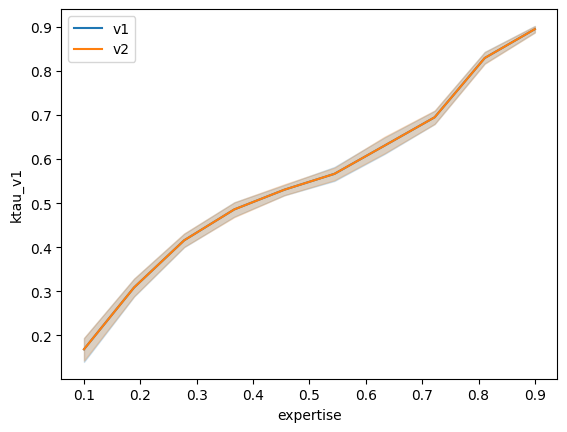

In [11]:
sns.lineplot(data=pd.DataFrame(results), x='expertise', y='ktau_v1', label='v1')
sns.lineplot(data=pd.DataFrame(results), x='expertise', y='ktau_v2', label='v2')